**Innovation or Inequality: Do Patent Litigations Lead to Exacerbated
Wealth Inequality?**



Section 1: Introduction


Wealth inequality is a pressing global issue, deepening economic divides and increasing vulnerability to financial shocks. One potential driver of inequality can be patent litigation, particularly its strategic use by dominant firms to suppress competition.

While patents incentivize investment in innovation by guaranteeing financial returns (Dam, 2002), they can also serve as tools for anti-competitive behavior. Large firms often leverage litigation to impose overwhelming legal costs on smaller competitors, ultimately consolidating market power and creating inefficient markets, higher prices, and reduced consumer choice (Drahos & Frankel, 2022). Legal scholarship highlights competing views on the role of intellectual property rights (IPRs) in inequality—Kapczynski (2015) argues that they may reinforce economic divides or function as a means of redistribution. Identifying the dominant mechanism is critical for policymakers seeking to address wealth inequality.

Empirical research on this issue remains inconclusive. While some studies suggest that patent enforcement exacerbates wealth disparities, particularly in innovation-driven economies (Saini & Mehra, 2018), others find contradictory results (Maskus, 2022). Given the global significance of wealth inequality and the complexity of IPR's economic effects, further research is essential.

This study examines the relationship between patent litigation and wealth inequality by analyzing USPTO litigation data alongside Gini coefficient trends in the U.S.. We incorporate key control variables—urbanization, unemployment, and inflation rates—to better isolate the impact of annual patent cases on inequality.



Section - 2: Data Cleaning and Loading

In [4]:
#importing useful packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
#Loading CSV files

#assigned data set: Patent Litigations
cases = pd.read_csv("/content/drive/My Drive/ECO225_Final_Project/PART1/cases.csv")

#y-variable from extternal sourc:e
gini = pd.read_csv("/content/drive/My Drive/ECO225_Final_Project/PART1/Gini.csv")

#3 new x-variables from external soruces:
urbanization = pd.read_csv("/content/drive/My Drive/ECO225_Final_Project/PART1/urbanization_rate.csv", on_bad_lines='skip')
unemployment = pd.read_csv("/content/drive/My Drive/ECO225_Final_Project/PART1/US-Unemployment.csv", on_bad_lines='skip')
inflation= pd.read_csv("/content/drive/My Drive/ECO225_Final_Project/PART1/inflation.csv", header=0,on_bad_lines='skip')

In [6]:
#isolating relevant variables from the raw litigations data
clean_cases = cases[['case_row_id', 'case_number', 'case_cause', 'date_filed', 'date_closed']]
clean_cases['year_closed'] = clean_cases['date_closed'].str[0:4].astype(float)
clean_cases['year_filed'] = clean_cases['date_filed'].str[0:4].astype(float)


#aggregating cases filed/closed by year
cases_closed = clean_cases.groupby('year_closed')['case_number'].nunique().reset_index()
cases_closed.columns = ['year', 'cases_closed']
cases_filed = clean_cases.groupby('year_filed')['case_number'].nunique().reset_index()
cases_filed.columns = ['year', 'cases_filed']

#new df containing total cases filed/closed in a given year
annual_cases = pd.merge(cases_filed, cases_closed, on='year', how='outer').fillna(0)
annual_cases[['cases_filed', 'cases_closed']] = annual_cases[['cases_filed', 'cases_closed']].astype(float)
annual_cases['year'] = annual_cases['year'].astype(int)

#cleaning unemployment df and computing avg annual unemployment rates for the US
unemployment['year'] = unemployment['observation_date'].str[0:4].astype(int)
clean_unemployment = pd.DataFrame()
clean_unemployment['year'] = unemployment['observation_date'].str[0:4].astype(int).unique()
clean_unemployment['unemployment_rate'] = (unemployment.groupby(unemployment['observation_date'].str[0:4].astype(int))['UNRATE'].mean().values)

#isolating annual gini coeff data for the US
clean_gini = pd.DataFrame()
clean_gini['year'] = gini['observation_date'].str[0:4].astype(int)
clean_gini['Gini Coeff.'] = gini['SIPOVGINIUSA']/100

#converting year columns to rows in clean_urbanization df
clean_urbanization = urbanization.melt(
    id_vars=['Country Name'],
    var_name='year',
    value_name='Urbanization Rate')

clean_urbanization['year'] = pd.to_numeric(clean_urbanization['year'], errors='coerce')
clean_urbanization = clean_urbanization.dropna(subset=['year'])
clean_urbanization['year'] = clean_urbanization['year'].astype(int)
clean_urbanization['Urbanization Rate'] = clean_urbanization['Urbanization Rate'].astype(float)
#isolating US data
clean_urbanization = clean_urbanization[clean_urbanization['Country Name'] == 'United States']
clean_urbanization = clean_urbanization.drop(columns=['Country Name'])
clean_urbanization = clean_urbanization.reset_index()


#converting year columns to rows in clean_inflation df
clean_inflation = inflation.melt(
    id_vars=['Country Name'],
    var_name='year',
    value_name='Inflation Rate')

clean_inflation['year'] = pd.to_numeric(clean_inflation['year'], errors='coerce')
clean_inflation = clean_inflation.dropna(subset=['year'])
clean_inflation['year'] = clean_inflation['year'].astype(int)
clean_inflation['Inflation Rate'] = clean_inflation['Inflation Rate'].astype(float)
#isolating US data
clean_inflation = clean_inflation[clean_inflation['Country Name'] == 'United States']
clean_inflation = clean_inflation.drop(columns=['Country Name'])
clean_inflation = clean_inflation.reset_index()

<ipython-input-6-54ff79516138>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_cases['year_closed'] = clean_cases['date_closed'].str[0:4].astype(float)
<ipython-input-6-54ff79516138>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_cases['year_filed'] = clean_cases['date_filed'].str[0:4].astype(float)


In [7]:
#merging all variables into one df
complete_merged = pd.DataFrame()
complete_merged = pd.merge(clean_gini, annual_cases, on='year', how='inner')
complete_merged = pd.merge(complete_merged, clean_urbanization, on='year', how='inner')
complete_merged = pd.merge(complete_merged, clean_unemployment, on='year', how='inner')
complete_merged = pd.merge(complete_merged, clean_inflation, on='year', how='inner')
complete_merged = complete_merged.drop(columns=['index_x'])
complete_merged = complete_merged.drop(columns=['index_y'])

In [8]:
#cleaned, merged data table
complete_merged = complete_merged.set_index('year').sort_index()
complete_merged.head()

,Gini Coeff.,cases_filed,cases_closed,Urbanization Rate,unemployment_rate,Inflation Rate
year,,,,,,
1963,0.376,1.0,1.0,71.134,5.641667,1.239669
1972,0.367,4.0,1.0,73.623,5.600000,3.272278
1973,0.361,0.0,1.0,73.633,4.858333,6.177760
1974,0.355,2.0,2.0,73.643,5.641667,11.054805
1975,0.356,4.0,2.0,73.653,8.475000,9.143147


Section - 3: Summary Statistics

In [9]:
from tabulate import tabulate

# Generate summary stats
summary_stats = complete_merged.describe().transpose()

# Add variable descriptions
summary_stats["Description"] = [
    "Gini coefficient (income inequality)",
    "Number of cases filed (agg. annually)",
    "Number of cases closed(agg. annually)",
    "Urbanization rate (%)",
    "Unemployment rate (%)",
    "Inflation rate (%)"]


summary_stats = summary_stats[["Description", "mean", "std", "min", "25%", "50%", "75%", "max"]]

# Creating a clean summary table
print(tabulate(summary_stats, headers="keys", tablefmt="grid"))

+-------------------+---------------------------------------+-------------+-------------+-----------+----------+------------+-----------+------------+
|                   | Description                           |        mean |         std |       min |      25% |        50% |       75% |        max |
+===================+=======================================+=============+=============+===========+==========+============+===========+============+
| Gini Coeff.       | Gini coefficient (income inequality)  |    0.389078 |    0.021659 |  0.347    |  0.373   |    0.4     |    0.407  |    0.415   |
+-------------------+---------------------------------------+-------------+-------------+-----------+----------+------------+-----------+------------+
| cases_filed       | Number of cases filed (agg. annually) | 1777.73     | 1686.98     |  0        | 52.5     | 1606       | 2722      | 5742       |
+-------------------+---------------------------------------+-------------+-------------+-----

The Summary Statistics tabulated above shows the means, standard deviations and quartiles for the Gini-Coefficient(Y) and our 5 Predictor(X) variables over 50
year.

The Gini Coefficient seems to have a left-ward skew because the mean as well as the 50th, 75th and 100th percentiles seem to lie between 0.38-0.41 roughly, while the 25th and 0th percentiles are at 0.37 and 0.347, respectively. This could suggest that Gini-coefficients have slowed down in terms of annual increases, assuming that there isn't any trend of decreasing income inequality in the US. The standard deviation is also only about 0.02 showing that inequality changes aren't too big in magnitude. This could potentially be an issue for our research because low variation could reduce the power of regression, to pick up an effect.

Cases Filed and Closed both have similar means, standard deviations and seem to follow a similar distribution with cases closed having marginally larger values. This suggests that there is a slight lag between cases filed and closed, which is expected since cases must be filed first and then resolved in subsequent years. There also seems to be insigicantl, small values in these variables, both have a min of 0 and less than 100 cases at the 25th percentile.
If these cases occur in the early years of the dataset, it might be useful to remove them as there likely isn't a strong effect on wealth inequality through a trivially small number of cases.

Urbanization rates appear to have a fairly normally distributed around a mean of 77% with a standard deviation of 3.3 roughly. Since we expect that urbanization almost exclusively increases with time and never goes down, in the U.S., this even distribution suggests that urbanization follows a fairly linear growth pattern. Since inequality also increases over time, urbanization could be a useful control variable and help in isolating the effect of litigations on inequality.

Unemployment seems to have a slight rightward skew and relatively high standard deviation. This can be expected is unemployment is highly variable, even though we are working with annualized unemployment. The distribution appears slightly left-skewed based on the values of the quartiles. The large variation could mean that unemployment isn't a good control for inequality.

Inflation has a very high standard deviation and an extreme right-skew. This is also expected as inflation has been annualized and thus reflects the average of the monthly variation in inflation within each year. The large variation could mean that inflation isn't a good control for inequality.

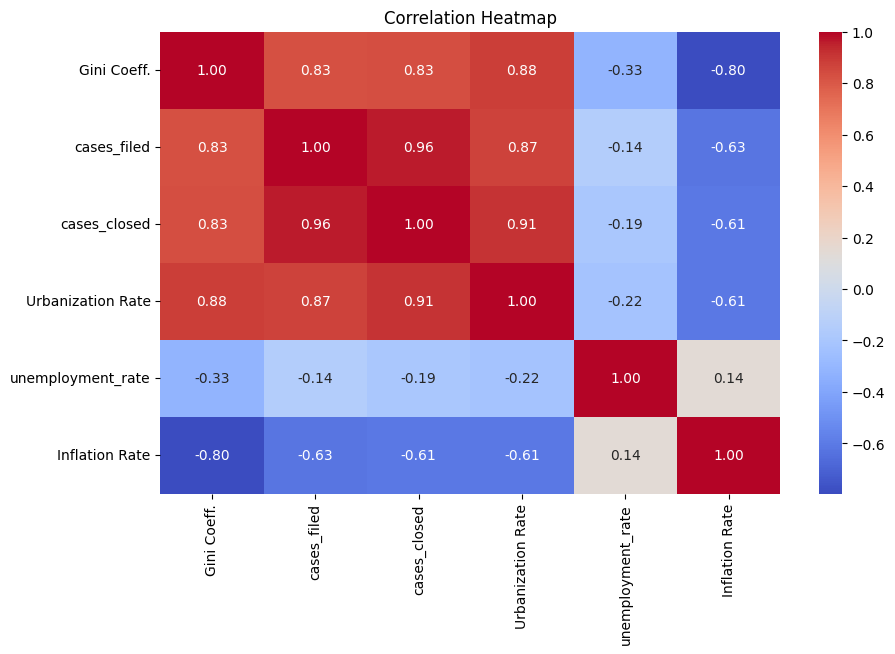

In [10]:
plt.figure(figsize=(10, 6))
sns.heatmap(complete_merged.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

The heat map above depicts the correlations between all of our dependent and independent variables.

The high positive correlations between cases filed and gini coeff. as well as between cases closed and the gini coeff. are promising as they suggest that there could be an impact of patent litigations on inequality, though a causal effect cannot be inferred bases on correlation alone.

Urbanization rates also have a very high positive correlation with inequality which suggests that it could be a useful control variable. Even though there appears to be positive correlation, patent litigations aren't expected to have any reasonable effect on urbanization, this suggests that there are likely many confounding factors that are causing this correlation. Thus adding urbanization as a control can help greatly in isolating the effect of patent litigations by reducing ommitted variable bias.

Surprisingly, both unemployment and inflation have negative correlations with all other variables in the data. Unemployment seems to have a low magnitude of these negative correlations whereas inflation appears to have a strong negative correlation with inequality(gini coeff.), in particular.

This seems contradictory to intuition as we expect low income groups to be more sensitive to unemployment and inflaiton as compared to their wealthy counterparts. This could potentially be attributed to last information through the annualization of unemployment and inflation data which is typically measured with quarterly or monthly frequency.

One possible explanation for inflation, is that in years with high inflation the Fed tends to raise interest rates which can reduce the rates of return on capital. Perhaps, this leads to the shortening of the income gap as the negative impact of interest rates on the rich stronger than the negative impact of inflation on the poor. However, there are too many confounding factors to be able to conclude anything significant, reliably.

Section - 4: Data Visualizations

In [14]:
complete_merged.head()

,Gini Coeff.,cases_filed,cases_closed,Urbanization Rate,unemployment_rate,Inflation Rate
year,,,,,,
1963,0.376,1.0,1.0,71.134,5.641667,1.239669
1972,0.367,4.0,1.0,73.623,5.600000,3.272278
1973,0.361,0.0,1.0,73.633,4.858333,6.177760
1974,0.355,2.0,2.0,73.643,5.641667,11.054805
1975,0.356,4.0,2.0,73.653,8.475000,9.143147


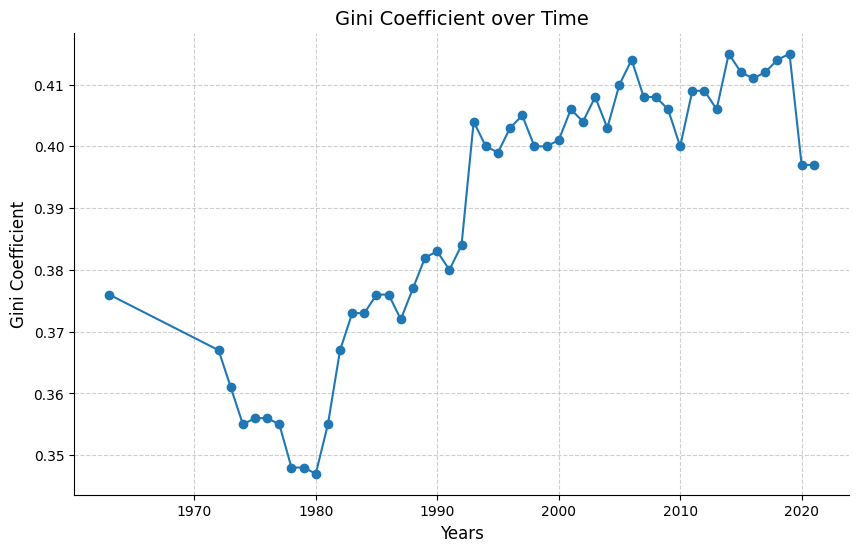

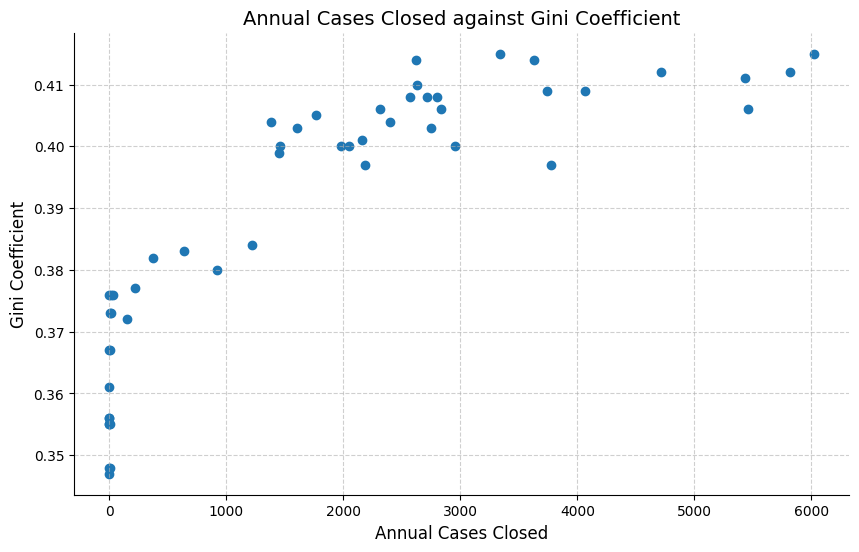

In [37]:
plt.figure(figsize=(10, 6))
plt.plot(complete_merged.index, complete_merged['Gini Coeff.'],  marker='o', linestyle='-')
plt.title(f'Gini Coefficient over Time', fontsize=14)
plt.xlabel('Years', fontsize=12)
plt.ylabel('Gini Coefficient', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.gca().spines[['top', 'right']].set_visible(False)
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(complete_merged['cases_closed'], complete_merged['Gini Coeff.'])
plt.title(f'Annual Cases Closed against Gini Coefficient', fontsize=14)
plt.xlabel('Annual Cases Closed', fontsize=12)
plt.ylabel('Gini Coefficient', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.gca().spines[['top', 'right']].set_visible(False)
plt.show()

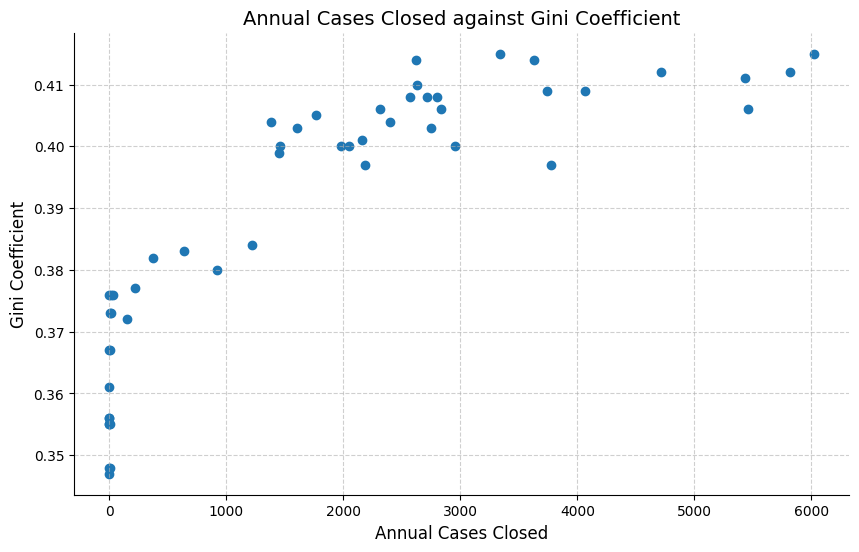

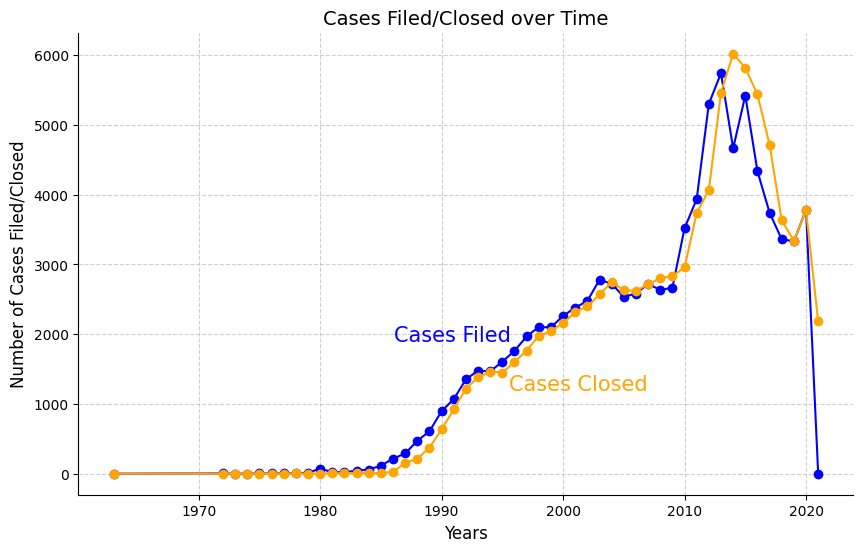

In [25]:
plt.figure(figsize=(10, 6))
plt.plot(complete_merged.index, complete_merged['cases_filed'],  marker='o', linestyle='-', color='blue')
plt.annotate('Cases Filed', (1995, 2000), textcoords="offset points", xytext=(-36,-5), ha='center', color="blue", fontsize=15)
plt.plot(complete_merged.index, complete_merged['cases_closed'],  marker='o', linestyle='-', color='orange')
plt.annotate('Cases Closed', (1995, 700), textcoords="offset points", xytext=(55, 25), ha='center', color='orange', fontsize=15)
plt.title(f'Cases Filed/Closed over Time', fontsize=14)
plt.xlabel('Years', fontsize=12)
plt.ylabel('Number of Cases Filed/Closed', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.gca().spines[['top', 'right']].set_visible(False)
plt.show()

Section - 5: Conclusion

References:


*   Dam, Kenneth W. 2002. The Economic Underpinnings of Patent Law. Chicago: University of Chicago Law School.
https://chicagounbound.uchicago.edu/cgi/viewcontent.cgi?article=1508&context=law_and_economics

*   Maskus, Keith E. 2022. Intellectual Property Rights and Economic Inequality: Theory and Evidence. Stockholm Intellectual Property Law Review, Vol. 5, Issue 1, September 2022.

*   Kapczynski, Amy. 2015. "Four Hypotheses on Intellectual Property and Inequality." Yale Law School Legal Scholarship Repository.
https://law.yale.edu/sites/default/files/documents/pdf/SELA15_Kapczynski_CV_Eng.pdf

*  Drahos, Peter, and Susy Frankel. 2022. Intellectual Property, Innovation, and Economic Inequality. Cambridge: Cambridge University Press.
https://www.cambridge.org/core/books/intellectual-property-innovation-and-economic-inequality/15F8912E63C4C397E0071E8F29B5B54B

*   Saini, S. S., and Meenakshi Mehra. 2018. "Impact of Strengthening Intellectual Property Rights Regime on Income Inequality: A Dynamic Panel Data Analysis." Economics Bulletin 38 (2): 1013-1023.



External Data Sources:





NameError: name 'complete_merged' is not defined